In [42]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from sklearn.feature_extraction.text import TfidfVectorizer;

[nltk_data] Downloading package punkt to C:\Users\Angelos
[nltk_data]     Pele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Reading the input data

In [43]:
df = pd.read_csv('Combined_News_DJIA.csv')

In [44]:
number_samples, number_columns = df.shape #number of dates by number of columns
number_articles = number_columns-2

#### Group by Year

In [45]:
def get_current_year(date):
    return int(date[:4])

#### Isolating words with spaces and converting to lowercase

In [46]:
for i in range(1, number_articles+1):
    col = "Top" + str(i)
    df[col] = df[col].apply(lambda x: re.sub('\W+', ' ', str(x)).lower().strip())

#### Removing stopwords and very small words

In [47]:
stop_words = stopwords.words('english')

for i in range(1, number_articles+1):
    col = "Top" + str(i)
    df[col] = df[col].apply(lambda x: ' '.join([w for w in x.split() if (len(w) >= 3) and (w not in stop_words)]))

#### Concatenate all documents in one series

In [48]:
all_columns = []
for i in range(2, number_articles+1):
    col = "Top" + str(i)
    all_columns.append(df.iloc[0:1][col])
documents = df.iloc[0:1]['Top1'].append(all_columns, ignore_index=True)

for row in range(1, number_samples):
    all_columns = []
    for i in range(1, number_articles+1):
        col = "Top" + str(i)
        all_columns.append(df.iloc[row:row+1][col])
    documents = documents.append(all_columns, ignore_index=True)

#### Prepare vectorizer with stemming

In [49]:
class StemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

#### Apply vectorizer

In [50]:
"""tokenizer=StemTokenizer(), """
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(documents)

#### Function that prints the top words for each topic

In [51]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

#### Fit and present topics

In [52]:
num_topics = 5
model = NMF(n_components=num_topics)
nmf = model.fit(X)

tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 10)

Topic #0: police new world year people government 000 killed years old
Topic #1: korea north south korean nuclear kim jong test missile launch
Topic #2: israel gaza israeli palestinian war hamas iran palestinians west bank
Topic #3: russia says ukraine iran russian putin syria nuclear military president
Topic #4: china chinese japan world sea india oil beijing billion global



#### Find the matrix with the topics per document

In [53]:
H = nmf.fit_transform(X)

In [54]:
H.sum(axis=0)

array([557.03176182, 165.31480813, 243.99932134, 306.83636056,
       208.39026704])

In [55]:
H.mean(axis=0)

array([0.01120225, 0.00332458, 0.00490697, 0.00617067, 0.00419086])

In [56]:
H = H.T

In [57]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
topic_number, document_number = H.shape
averages = []
i=0
start = 2008.5
end = 2016.5
dates = []
while(i < document_number):
    running_sum = H[:, i:i+1]
    i+=1
    count = 0
    while (i)%1000 != 0:
        running_sum = running_sum + H[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start) * i/document_number)
averages = np.hstack(average for average in averages)
averages.shape

(5, 49)

In [58]:
sns.set()

Text(0,0.5,'Relevance of topic')

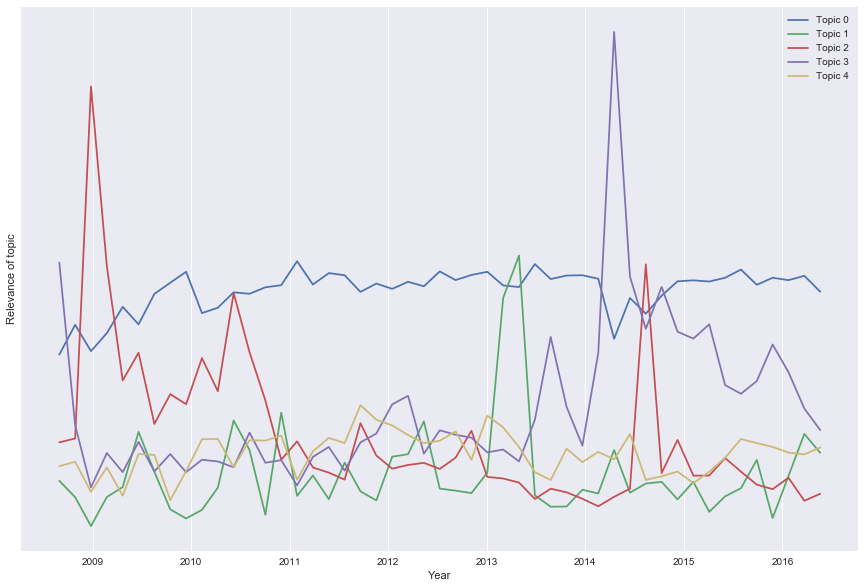

In [59]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(15,10))
plt.plot(dates[:-1],averages.T)
plt.legend(["Topic "+str(i) for i in [0, 1, 2, 3, 4]])
plt.yticks([])
plt.xlabel('Year')
plt.ylabel('Relevance of topic')

In [40]:
averages

array([[0.00840614, 0.00968173, 0.00855346, 0.00932503, 0.01045215,
        0.00969984, 0.01100878, 0.01148286, 0.01195388, 0.01018278,
        0.01041388, 0.01107378, 0.01100984, 0.01128897, 0.01137806,
        0.01240608, 0.01140731, 0.01189687, 0.011805  , 0.01109117,
        0.01144902, 0.01122132, 0.01152412, 0.01133167, 0.01196907,
        0.01159758, 0.01181699, 0.01195208, 0.01136765, 0.01129961,
        0.01228359, 0.01164133, 0.01179274, 0.0118052 , 0.01165448,
        0.00908366, 0.01082972, 0.01015734, 0.01093288, 0.01154445,
        0.01158703, 0.01153624, 0.01169528, 0.01204887, 0.011395  ,
        0.01169848, 0.0115949 , 0.01177954, 0.01110105],
       [0.0030167 , 0.00230916, 0.00106472, 0.00231496, 0.00274358,
        0.00512069, 0.00339632, 0.00178508, 0.00139144, 0.0017622 ,
        0.00272033, 0.00561134, 0.00433925, 0.0015491 , 0.00594793,
        0.00236447, 0.00324203, 0.00222348, 0.00379665, 0.00255901,
        0.00217184, 0.00405145, 0.00415947, 0.0055703 , 0.0

In [109]:
df.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,barclays rbs shares suspended trading tanking,pope says church ask forgiveness gays past tre...,poland shocked xenophobic abuse poles,second referendum cabinet agrees,scotland welcome join merkel ally says,sterling dips friday year low amid brexit unce...,negative news south african president allowed ...,surge hate crimes following brexit vote,...,german lawyers probe erdogan alleged war crimes,boris johnson says continue intensify cooperat...,richard branson calling government hold second...,turkey sorry downing russian jet,edward snowden lawyer vows new push pardon obama,brexit opinion poll reveals majority want seco...,conservative leave campaigner leave campaign p...,economists predict recession weakening pound f...,new superstate plan france germany creating eu...,pakistani clerics declare transgender marriage...
1985,2016-06-28,1,500 scientists australia want save great barri...,personal details 112 000 french police officer...,amp cuts united kingdom sovereign credit ratin...,huge helium deposit found africa,ceo south african state broadcaster quits shor...,brexit cost investors trillion worst one day d...,hong kong democracy activists call return brit...,brexit iceland president says join triangle no...,...,canada mexico pledge power clean energy 2025,increasing evidence australia torturing refuge...,richard branson founder virgin group said tues...,000 old skull borneo reveals surprise scientis...,palestinians stone western wall worshipers pol...,jean claude juncker asks farage,romanians remainians offering new home britons...,brexit gibraltar talks scotland stay,suicide bombers strike lebanon,mexico security forces routinely use sexual to...
1986,2016-06-29,1,explosion airport istanbul,yemeni former president terrorism offspring wa...,must accept freedom movement access market,devastated scientists late captive breed mamma...,british labor party leader jeremy corbyn loses...,muslim shop firebombed people inside,mexican authorities sexually torture women prison,shares pound continue recover,...,escape tunnel dug hand found holocaust massacr...,land beijing sinking much four inches per year...,car bomb anti islamic attack mosque perth aust...,emaciated lions taiz zoo trapped blood soaked ...,rupert murdoch describes brexit wonderful medi...,killed yemen suicide attacks,google found disastrous symantec norton vulner...,extremist violence rise germany domestic intel...,bbc news labour mps pass corbyn confidence motion,tiny new zealand town many jobs launches drive...
1987,2016-06-30,1,jamaica proposes marijuana dispensers tourists...,stephen hawking says pollution stupidity still...,boris johnson says run tory party leadership,six gay men ivory coast abused forced flee hom...,switzerland denies citizenship muslim immigran...,palestinian terrorist stabs israeli teen girl ...,puerto rico default billion debt friday,republic ireland fans awarded medal sportsmans...,...,googles free wifi indian railway stations bett...,mounting evidence suggests hobbits wiped moder...,men carried tuesday terror attack istanbul ata...,calls suspend saudi arabia human rights counci...,100 nobel laureates call greenpeace anti gmo o...,british pedophile sentenced years trafficking ...,permitted 200 offshore fracks gulf mexico 2010...,swimming ridicule french beach police carry gu...,uefa says minutes silence istanbul victims eur...,law enforcement sources gun used paris terrori...
1988,2016-07-01,1,117 year old woman mexico city finally receive...,imf chief backs athens permanent olympic host,president france says brexit donald trump,british man must give police hours notice sex ...,100 nobel laureates urge greenpeace stop oppos...,brazil huge spike number police killings rio a...,austria highest court annuls presidential elec...,facebook wins privacy case track belgian wants...,...,united states placed myanmar uz

In [80]:
print(SnowballStemmer("english").stem("generously"))

generous
